# Notebook 4: Análisis Espectro-Temporal de EEG mediante STFT y Espectrogramas

**Materias relacionadas:** Instrumentación Biomédica, Electrofisiología, Procesamiento Digital de Señales, Temas Selectos en Biomatemáticas y Temas Selectos en Biofísica.  
**Antecedentes:** Notebook 1, Notebook 2 y Notebook 3.  
**Objetivo:** Comprender la Transformada de Fourier de Tiempo Corto (STFT) y su aplicación en la construcción e interpretación de espectrogramas para el análisis espectro-temporal de señales EEG.

## 4.1 Introducción

Los métodos espectrales clásicos, como la **Transformada Rápida de Fourier (FFT)** y la **Densidad Espectral de Potencia (PSD)**, proporcionan información sobre la composición frecuencial de una señal, pero no permiten conocer **en qué momento del tiempo** ocurren los eventos que generan dichos componentes. Esta limitación es importante en el caso del EEG, donde los ritmos cerebrales cambian de manera dinámica a lo largo del tiempo debido a la naturaleza no estacionaria del sistema nervioso central (Cohen, 2014).

En contextos clínicos y experimentales, la información temporal del contenido espectral es esencial para analizar fenómenos como:

- **Transitorios espectrales**, donde aparecen oscilaciones breves asociadas con estímulos sensoriales o tareas cognitivas.  
- **Reactividad alfa**, caracterizada por la variación de la potencia en la banda de 8–12 Hz entre condiciones de ojos abiertos (OA) y ojos cerrados (OC).  
- **Eventos patológicos**, como las descargas epileptiformes, que presentan componentes espectrales definidos pero de corta duración.  
- **Transiciones de estado**, como los cambios progresivos entre alerta, somnolencia y sueño, que alteran la distribución temporal de la energía espectral.

Para describir estos procesos, se requieren técnicas que combinen simultáneamente **resolución temporal** y **resolución frecuencial**. La **Transformada de Fourier de Tiempo Corto (Short-Time Fourier Transform, STFT)** introduce esta capacidad mediante la aplicación de la transformada de Fourier a segmentos locales de la señal definidos por una **ventana deslizante** (Allen & Rabiner, 1977; Flandrin, 1999). El resultado es una función bidimensional \( S(t,f) \) que describe cómo la energía de la señal se distribuye en el tiempo y en la frecuencia (Boashash, 2016).

El **espectrograma** es la representación visual de esta función, donde los ejes corresponden a tiempo y frecuencia, y el color o intensidad indica la potencia o amplitud del componente espectral. Su interpretación es directa: regiones de alta densidad energética reflejan actividad dominante en una frecuencia particular durante un intervalo temporal determinado.

En el ámbito del EEG, los espectrogramas permiten identificar **fluctuaciones dinámicas de energía en bandas fisiológicas** (θ: 4–7 Hz, α: 8–12 Hz, β: 13–30 Hz, γ: >30 Hz) y evaluar la relación entre los ritmos cerebrales y los procesos neuronales subyacentes (Hsu, Lin, & Hsu, 2021). Este enfoque constituye una extensión natural del análisis espectral desarrollado en los notebooks anteriores, integrando ahora la dimensión temporal de los procesos neuroeléctricos.

En este cuaderno se abordarán los fundamentos matemáticos de la STFT, la definición de sus parámetros de implementación (ventana, solapamiento y tamaño de segmento), y la aplicación práctica a señales EEG reales del canal occipital O1, con el fin de estudiar la dinámica espectro-temporal durante la transición OA/OC.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import os

# --- Parámetros generales ---
fs = 128  # Hz
canal = 6  # Canal O1
ti_abiertos, tf_abiertos = 105, 120  # Intervalo OA

# --- Ruta del archivo ---
ruta = "/Users/dianavazquezperez/Documents/DianaTesis/Datos/EEG/H24_OC_OA.csv"

# --- Carga y filtrado Butterworth (2–45 Hz) ---
datos = pd.read_csv(ruta)
lowcut, highcut = 2, 45
orden = 4
b, a = signal.butter(orden, [lowcut/(fs/2), highcut/(fs/2)], btype='bandpass')
datosfilt = signal.filtfilt(b, a, datos.to_numpy(), axis=0)
datosfilt = pd.DataFrame(datosfilt, columns=datos.columns)

## 4.2 Fundamentos biomatemáticos de la Transformada de Fourier de Tiempo Corto (STFT)

La Transformada de Fourier de Tiempo Corto (STFT) es la técnica fundamental para el análisis tiempo-frecuencia. Extiende la FFT (que promedia la frecuencia sobre todo el tiempo) aplicando la transformada de Fourier repetidamente a pequeños segmentos solapados de la señal.

Esto se logra multiplicando la señal $x(t)$ por una **función ventana** $w(t)$ (como una ventana de Hann o Bartlett) que está localizada en el tiempo. Esta ventana se desliza a lo largo de la señal, y se calcula una FFT para cada segmento "enventanado" (Allen & Rabiner, 1977).

Formalmente, la STFT de una señal $x(t)$ se define como:

$$
X(t, f) = \int_{-\infty}^{\infty} x(\tau)\,w(\tau - t)\,e^{-i2\pi f \tau}\,d\tau
$$

Donde:
* $x(\tau)$ es la señal original.
* $w(\tau - t)$ es la función ventana centrada en el instante $t$.
* $X(t,f)$ es la STFT, un valor complejo que representa la amplitud y la fase de la frecuencia $f$ en el tiempo $t$.

### El Espectrograma y la PSD

Para la visualización, raramente usamos la STFT compleja. En su lugar, calculamos el **Espectrograma** $S(t,f)$, que es la magnitud al cuadrado de la STFT. Esto representa la **Densidad Espectral de Potencia (PSD)** de la señal en función del tiempo y la frecuencia (Cohen, 1995):

$$
S(t,f) = |X(t,f)|^2
$$

Este método está estrechamente relacionado con el método de Welch, que promedia periodogramas modificados (calculados sobre segmentos solapados) para obtener una estimación de la PSD con varianza reducida. El espectrograma es, en esencia, la visualización de estos periodogramas individuales a lo largo del tiempo antes de promediarlos.

### El Compromiso Tiempo-Frecuencia

La STFT está fundamentalmente limitada por el **Principio de Incertidumbre de Gabor** (derivado del de Heisenberg), que establece que no es posible conocer simultáneamente la frecuencia exacta y el tiempo exacto de un evento en la señal (Gabor, 1946). Matemáticamente:

$$
\Delta t \cdot \Delta f \geq \frac{1}{4\pi}
$$

Este principio introduce un **compromiso (trade-off)** práctico controlado por la **longitud de la ventana**:

1.  **Ventana Larga** (ej. 2 segundos): Captura muchos ciclos de la señal.
    * **Buena Resolución Frecuencial ( $\Delta f$ pequeña):** Puede distinguir entre 9 Hz y 10 Hz.
    * **Mala Resolución Temporal ( $\Delta t$ grande):** Si un evento rápido (como un artefacto) ocurre, se "embarrará" a lo largo de los 2 segundos, y no sabremos exactamente *cuándo* sucedió.

2.  **Ventana Corta** (ej. 0.2 segundos):
    * **Mala Resolución Frecuencial ( $\Delta f$ grande):** No puede distinguir bien entre 9 Hz y 10 Hz; aparecerán como una sola banda ancha.
    * **Buena Resolución Temporal ( $\Delta t$ pequeña):** Puede localizar con precisión el evento rápido en el tiempo.

### Parámetros Clave en Python

En `scipy.signal.stft` y `scipy.signal.spectrogram`, este compromiso se controla principalmente con:

| Parámetro (`scipy`) | Significado | Efecto |
| :--- | :--- | :--- |
| `fs` | Frecuencia de muestreo (Hz) | Define el rango máximo de frecuencias analizables (Frecuencia de Nyquist = $f_s/2$). |
| `window` | Tipo de ventana (ej: 'hann', 'bartlett') | Controla la fuga espectral (energía que "escapa" a frecuencias adyacentes) (Harris, 1978). |
| `nperseg` | Número de muestras por segmento | **Controla el compromiso $\Delta t / \Delta f$**. Mayor `nperseg` $\rightarrow$ mejor $\Delta f$, peor $\Delta t$. |
| `noverlap` | Número de muestras de solapamiento | Afecta la resolución temporal aparente. Mayor solapamiento $\rightarrow$ mejor $\Delta t$, más cómputo. |
| `mode` | Salida (ej. 'psd', 'magnitude') | Define la magnitud representada (PSD, magnitud, ángulo, etc.). |



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import signal
from scipy.fft import fft, fftshift
import os.path as os
from scipy.fftpack import fft, ifft
from scipy.signal import filtfilt, butter, spectrogram, stft
from scipy.integrate import simpson
import seaborn as sns

In [3]:


# Cargar datos originales
ruta = '/Users/dianavazquezperez/Documents/DianaTesis/Datos/EEG/H24_OC_OA.csv'
datos = pd.read_csv(ruta)

# Extraer matriz de datos y definir parámetros
eeg = datos.values
fm = 128  # Frecuencia de muestreo [Hz]
t = np.arange(len(eeg)) / fm

# Parámetros del filtro Butterworth
orden = 4
fc_low = 2
fc_high = 45
Wn = [fc_low / (fm / 2), fc_high / (fm / 2)]

# Diseño del filtro paso banda
b, a = signal.butter(orden, Wn, btype='bandpass')

# Aplicación del filtro a TODAS las columnas del EEG
datosfilt = signal.filtfilt(b, a, eeg, axis=0)

print('Filtro Butterworth 2–45 Hz (orden 4) aplicado correctamente a todo el dataset EEG.')


Filtro Butterworth 2–45 Hz (orden 4) aplicado correctamente a todo el dataset EEG.


## 4.3 ¿Qué es un Espectrograma?

Mientras que la STFT ($X(t, f)$) es una representación matemática compleja, el **Espectrograma** ($S(t,f)$) es su representación visual en términos de potencia. Es la herramienta que nos permite *ver* la dinámica de la señal.

El espectrograma es, en esencia, una imagen donde la energía de la señal se grafica en función del tiempo y la frecuencia (Cohen, 1995; Boashash, 2016).

### Interpretación Visual

* **Eje Horizontal (Eje X):** Representa el **Tiempo** (en segundos).
* **Eje Vertical (Eje Y):** Representa la **Frecuencia** (en Hertz, Hz).
* **Color/Intensidad:** Representa la **Potencia** o magnitud de la señal en esa frecuencia y en ese instante de tiempo.

**Escala Logarítmica (dB):**
En el EEG, la potencia de las oscilaciones de baja frecuencia (como alfa o delta) es órdenes de magnitud mayor que la de las altas frecuencias (como gamma). Para poder visualizar ambos extremos en el mismo gráfico, la potencia casi siempre se convierte a una escala logarítmica, en **decibelios (dB)**:

$S_{dB}(t,f) = 10 \cdot \log_{10}(S(t,f))$

Esto comprime el rango de valores, permitiendo que tanto los picos alfa (altos) como la actividad beta/gamma (baja) sean visibles simultáneamente.

### Bandas Fisiológicas del EEG
En el contexto del EEG, interpretamos los espectrogramas buscando actividad en bandas de frecuencia específicas (Hsu et al., 2021; Cohen, 2014):

* **Delta (δ):** < 4 Hz. (Sueño profundo, anestesia, algunas lesiones cerebrales).
* **Theta (θ):** 4–7 Hz. (Somnolencia, meditación, ciertos procesos de memoria).
* **Alfa (α):** 8–13 Hz. (Estado de vigilia relajada, dominante en regiones occipitales con ojos cerrados).
* **Beta (β):** 13–30 Hz. (Estado de alerta activa, concentración, actividad motora).
* **Gamma (γ):** > 30 Hz. (Procesamiento cognitivo complejo, integración sensorial).

En las siguientes secciones, usaremos el espectrograma para visualizar cómo cambia la potencia en estas bandas, específicamente la reactividad de la banda Alfa en el canal O1.
## 4.4 STFT con Ventana de Bartlett

### 4.4.1 Ventana de Bartlett: características y aplicación en EEG

La **ventana de Bartlett** se define matemáticamente como:

$$w(n) = 1 - \left| \frac{2n}{N-1} - 1 \right|$$

donde N es la longitud de la ventana. Esta ventana ofrece características relevantes para el análisis de EEG: forma simétrica, buena concentración espectral, reducción de la distorsión por ventana y menor varianza en la estimación espectral (Harris, 1978).

Período ojos abiertos: 120-150s
Longitud de señal: 3840 puntos
Longitud de ventana: 256 puntos (2.0s)


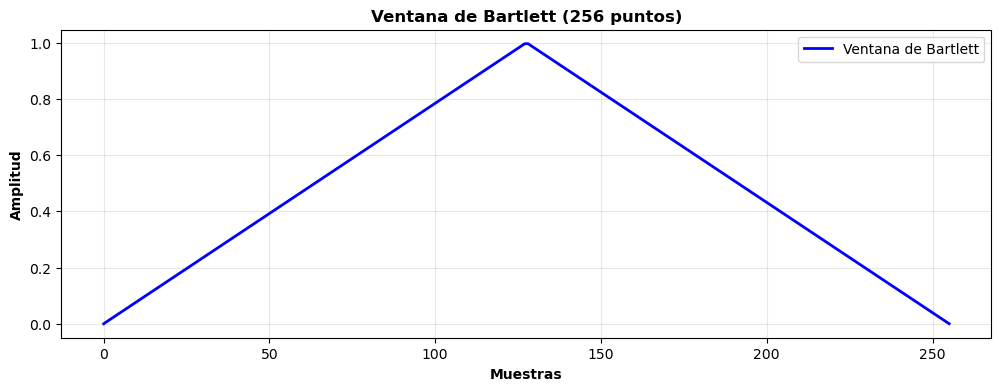

Resolución de frecuencia: 0.500 Hz


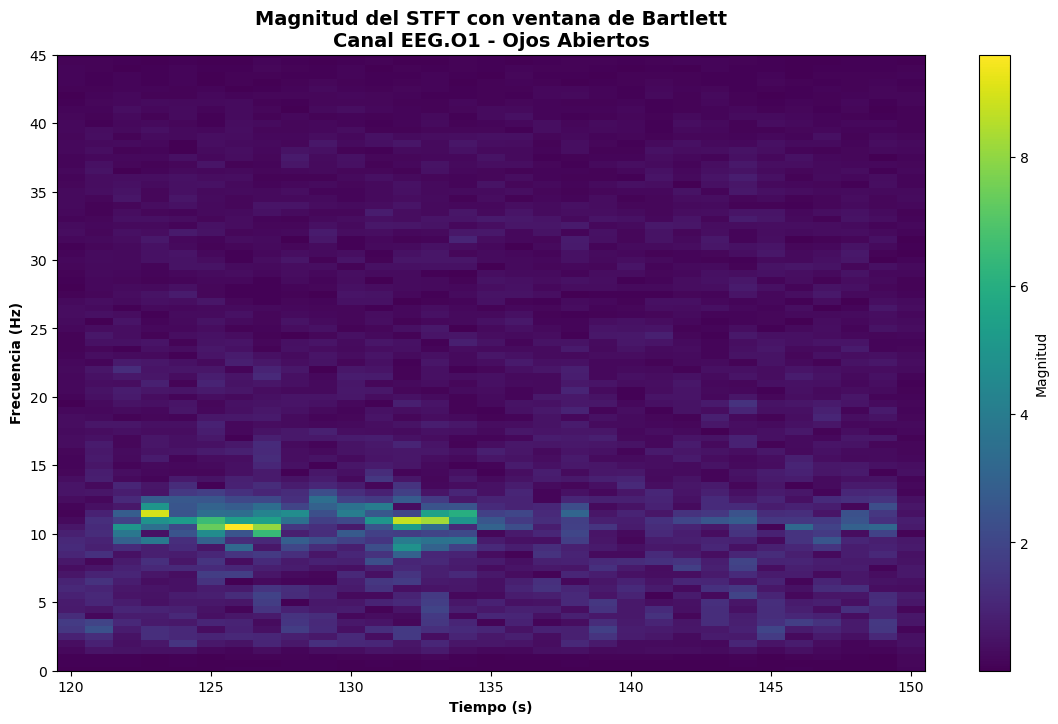

In [4]:
# Parámetros de entrada para análisis STFT
nc = 6  # Canal O1 (occipital)
ti_a = 120  # Ojos abiertos - tiempo inicio
tf_a = 150  # Ojos abiertos - tiempo final
pt_a = (tf_a - ti_a) * fm
t1_a = ti_a * fm
t2_a = tf_a * fm
t_a = np.linspace(ti_a, tf_a, pt_a)

# Datos de la señal para ojos abiertos
y_abiertos = np.array(datosfilt)[t1_a:t2_a, nc]
longitud_senal = len(y_abiertos)
longitud_ventana = 256

print(f"Período ojos abiertos: {ti_a}-{tf_a}s")
print(f"Longitud de señal: {longitud_senal} puntos")
print(f"Longitud de ventana: {longitud_ventana} puntos ({longitud_ventana/fm:.1f}s)")

# Ventana de Bartlett
ventana = scipy.signal.windows.bartlett(longitud_ventana)

# Visualizar la ventana de Bartlett
plt.figure(figsize=(12, 4))
plt.plot(ventana, 'b-', linewidth=2, label='Ventana de Bartlett')
plt.xlabel('Muestras', fontweight='bold')
plt.ylabel('Amplitud', fontweight='bold')
plt.title('Ventana de Bartlett (256 puntos)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Parámetros de superposición
superposicion = 128  # 50% de superposición
superposicion = min(longitud_ventana - 1, max(0, superposicion))

# Resolución de frecuencia
resolucion_frecuencia = fm / float(longitud_ventana)
print(f"Resolución de frecuencia: {resolucion_frecuencia:.3f} Hz")

# Calcular STFT con ventana de Bartlett
f, t, Zxx = scipy.signal.stft(y_abiertos, fs=fm, window=ventana, 
                              nperseg=longitud_ventana, noverlap=superposicion)

# Visualizar la magnitud del STFT
plt.figure(figsize=(14, 8))
plt.pcolormesh(t + ti_a, f, np.abs(Zxx), shading='auto', cmap='viridis')
plt.title('Magnitud del STFT con ventana de Bartlett\nCanal EEG.O1 - Ojos Abiertos', 
          fontweight='bold', fontsize=14)
plt.xlabel('Tiempo (s)', fontweight='bold')
plt.ylabel('Frecuencia (Hz)', fontweight='bold')
plt.colorbar(label='Magnitud')
plt.ylim(0, 45)  # Limitar a frecuencias de interés en EEG
plt.show()

### 4.4.2 Efecto de la superposición de ventanas

La superposición entre ventanas consecutivas es un parámetro crítico que afecta significativamente la calidad del análisis espectro-temporal. A mayor superposición, se obtiene mejor resolución temporal pero a costa de mayor carga computacional (Cohen, 2019).

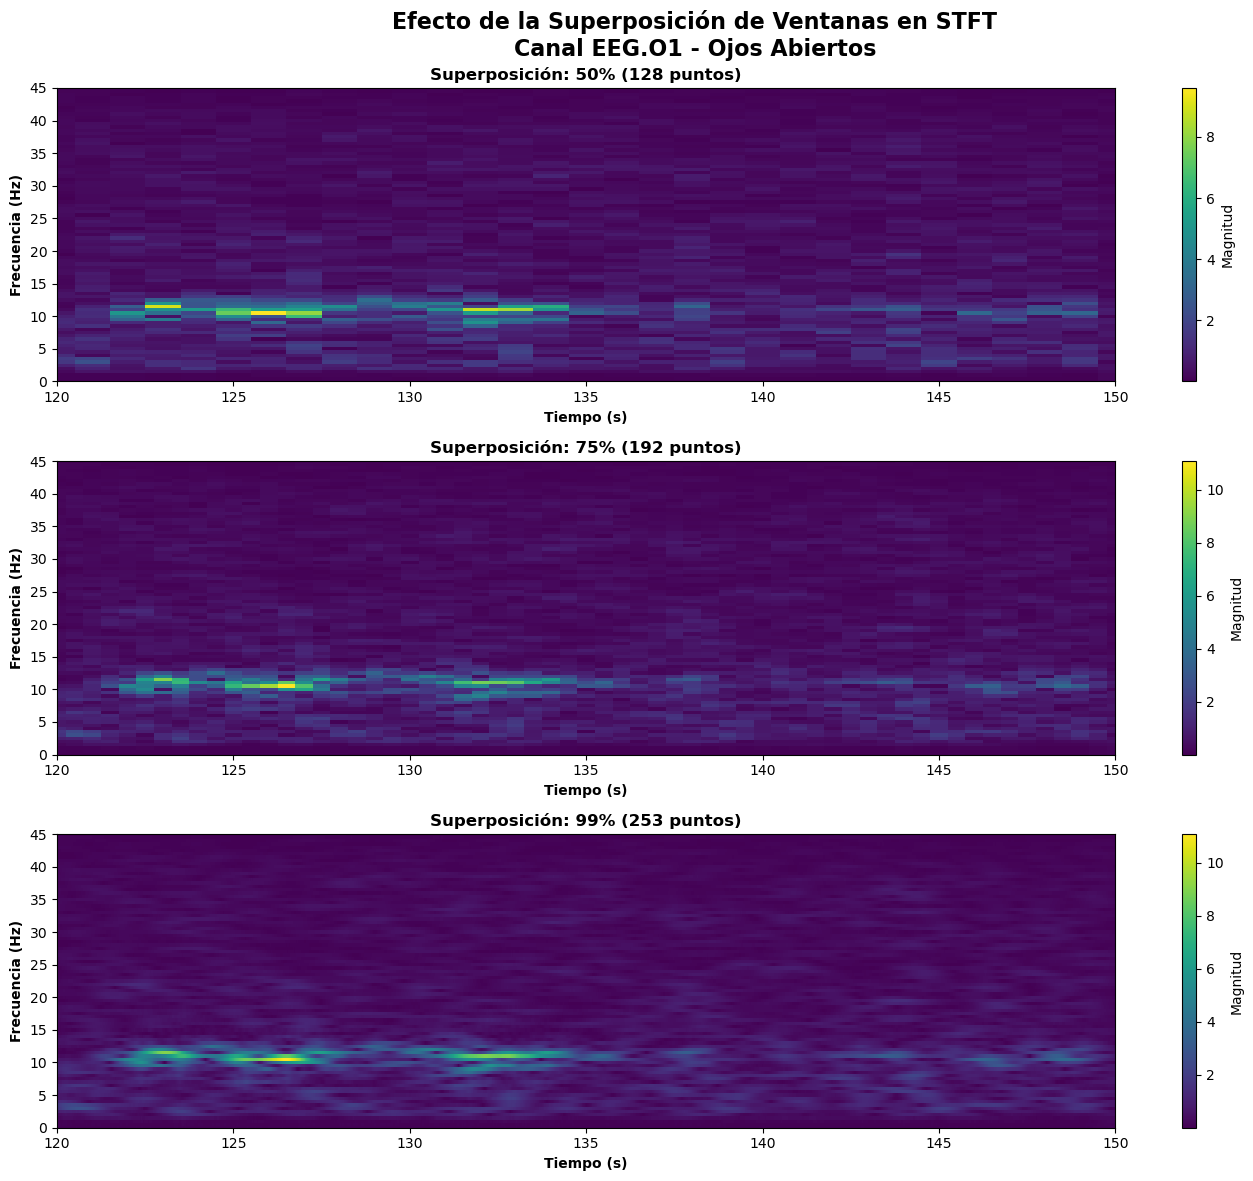

In [5]:
# Análisis del efecto de superposición
superposiciones = [0.5, 0.75, 0.99]  # 50%, 75%, 99%

# Crear figura con subplots para cada superposición
fig, axs = plt.subplots(len(superposiciones), 1, figsize=(14, 12))

for i, superposicion_pct in enumerate(superposiciones):
    # Ajustar la superposición
    noverlap = int(longitud_ventana * superposicion_pct)
    
    # Calcular STFT
    f, t, Zxx = scipy.signal.stft(y_abiertos, fs=fm, window=ventana, 
                                  nperseg=longitud_ventana, noverlap=noverlap)
    
    # Visualizar la magnitud del STFT
    im = axs[i].pcolormesh(t + ti_a, f, np.abs(Zxx), shading='auto', cmap='viridis')
    axs[i].set_title(f'Superposición: {superposicion_pct:.0%} ({noverlap} puntos)', 
                     fontweight='bold')
    axs[i].set_xlabel('Tiempo (s)', fontweight='bold')
    axs[i].set_xlim([ti_a, tf_a])
    axs[i].set_ylabel('Frecuencia (Hz)', fontweight='bold')
    axs[i].set_ylim(0, 45)
    
    # Añadir colorbar individual
    plt.colorbar(im, ax=axs[i], label='Magnitud')

plt.suptitle('Efecto de la Superposición de Ventanas en STFT\nCanal EEG.O1 - Ojos Abiertos', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.4.3 Interpretación del efecto de superposición

Los resultados muestran cómo la superposición afecta la visualización del espectrograma:

**Superposición 50%:** Proporciona una representación básica con resolución temporal limitada. Los cambios espectrales aparecen menos suaves y pueden perderse transitorios rápidos.

**Superposición 75%:** Ofrece un balance óptimo entre resolución temporal y carga computacional. Esta configuración es estándar en muchas aplicaciones clínicas de EEG.

**Superposición 99%:** Máxima resolución temporal, revelando detalles finos en la evolución espectral. Sin embargo, introduce redundancia computacional significativa.

Según Allen & Rabiner (1977), una superposición del 75% es generalmente óptima para la mayoría de aplicaciones de análisis espectral en señales biomédicas.

## 4.5 Espectrogramas Comparativos: Ojos Abiertos vs Ojos Cerrados

### 4.5.1 Fundamentos neurofisiológicos de la reactividad alfa

La reactividad alfa es un fenómeno neurofisiológico fundamental que refleja la integridad del sistema tálamo-cortical. Durante el estado de ojos cerrados, las redes neurales occipitales generan oscilaciones sincronizadas en la banda alfa (8-13 Hz), que se suprimen al abrir los ojos debido al procesamiento visual activo (Klimesch, 2012).

In [6]:
# Configurar períodos para comparación
ti_cerrados = 123  # Ojos cerrados - tiempo inicio
tf_cerrados = 133  # Ojos cerrados - tiempo final
pt_cerrados = (tf_cerrados - ti_cerrados) * fm
t1_cerrados = ti_cerrados * fm
t2_cerrados = tf_cerrados * fm

# Extraer datos para ojos cerrados
y_cerrados = np.array(datosfilt)[t1_cerrados:t2_cerrados, nc]

print(f"Configuración para análisis comparativo:")
print(f"Ojos abiertos: {ti_a}s - {tf_a}s ({len(y_abiertos)} puntos)")
print(f"Ojos cerrados: {ti_cerrados}s - {tf_cerrados}s ({len(y_cerrados)} puntos)")


Configuración para análisis comparativo:
Ojos abiertos: 120s - 150s (3840 puntos)
Ojos cerrados: 123s - 133s (1280 puntos)


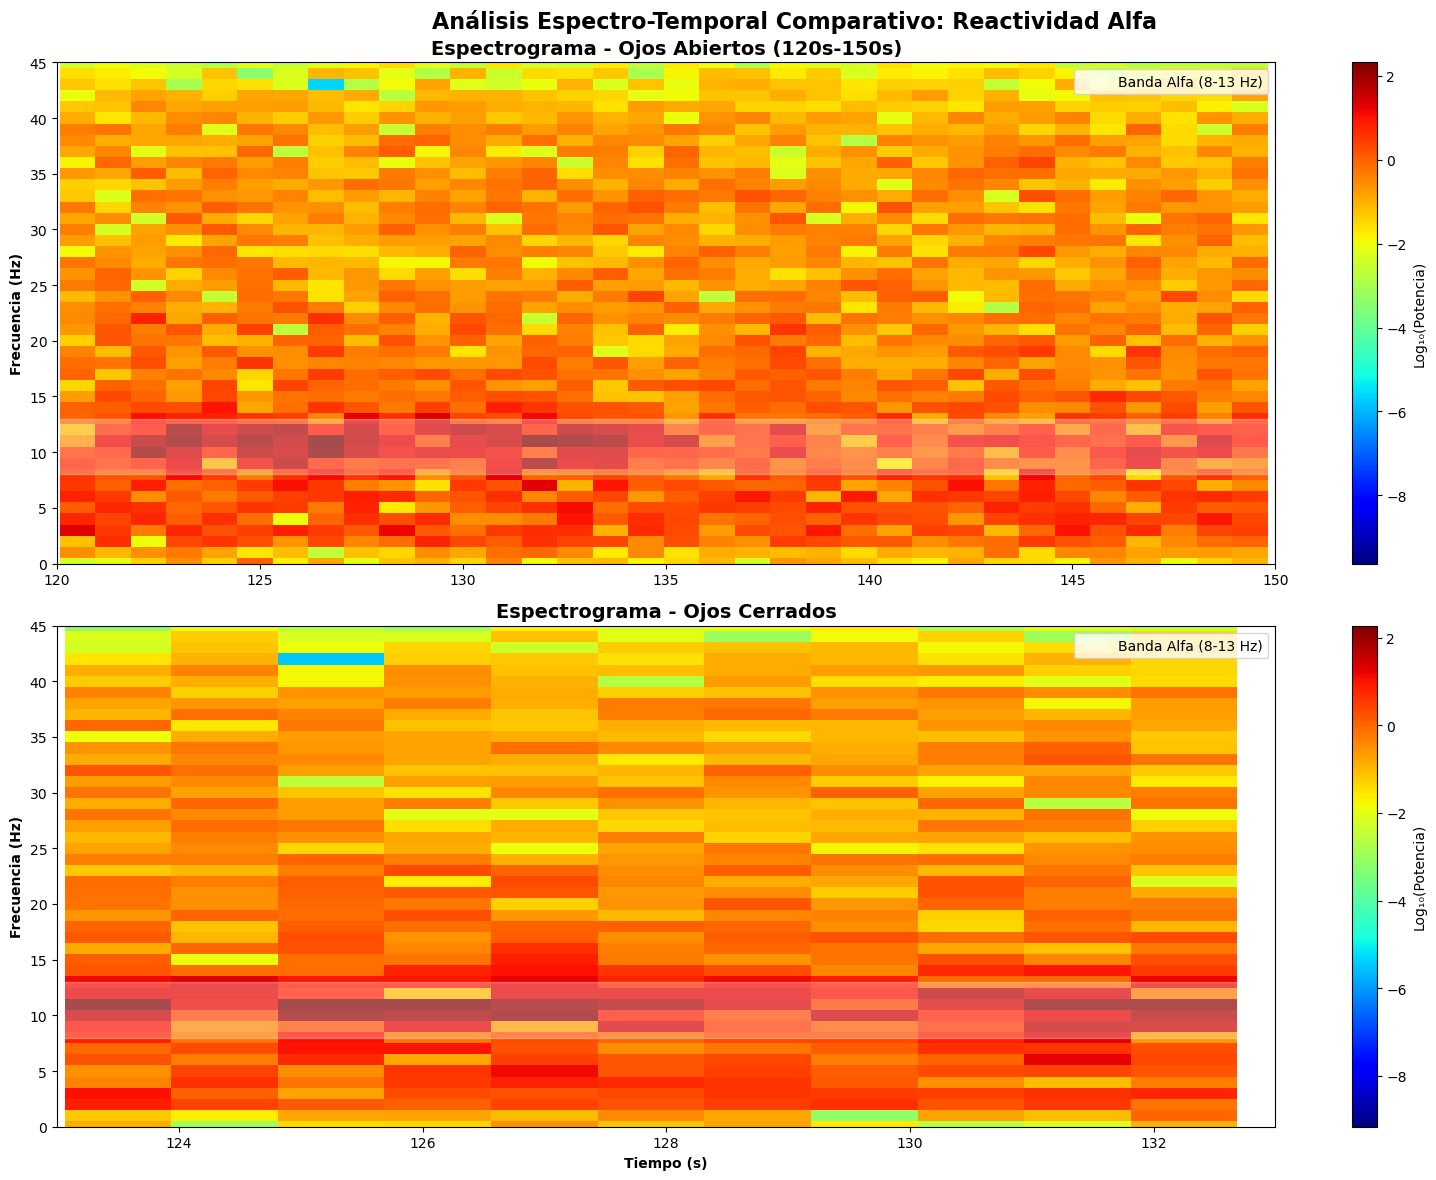

In [7]:
# Crear espectrogramas comparativos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Espectrograma - Ojos Abiertos
f_a, t_a_stft, sxx_a = signal.spectrogram(y_abiertos, fm, nperseg=128, scaling='spectrum')
im1 = ax1.pcolormesh(t_a_stft + ti_a, f_a, np.log10(sxx_a + 1e-12), cmap='jet', shading='auto')
ax1.set_ylabel('Frecuencia (Hz)', fontweight='bold')
ax1.set_title(f'Espectrograma - Ojos Abiertos ({ti_a}s-{tf_a}s)', 
              fontweight='bold', fontsize=14)
ax1.set_xlim(ti_a, tf_a)
ax1.set_ylim(0, 45)
plt.colorbar(im1, ax=ax1, label='Log₁₀(Potencia)')

# Destacar banda alfa
ax1.axhspan(8, 13, alpha=0.3, color='white', label='Banda Alfa (8-13 Hz)')
ax1.legend(loc='upper right')

# Espectrograma - Ojos Cerrados
f_c, t_c_stft, sxx_c = signal.spectrogram(y_cerrados, fm, nperseg=128, scaling='spectrum')
im2 = ax2.pcolormesh(t_c_stft + ti_cerrados, f_c, np.log10(sxx_c + 1e-12), cmap='jet', shading='auto')
ax2.set_ylabel('Frecuencia (Hz)', fontweight='bold')
ax2.set_xlabel('Tiempo (s)', fontweight='bold')
ax2.set_title(f'Espectrograma - Ojos Cerrados', 
              fontweight='bold', fontsize=14)
ax2.set_xlim(ti_cerrados, tf_cerrados)
ax2.set_ylim(0, 45)
plt.colorbar(im2, ax=ax2, label='Log₁₀(Potencia)')

# Destacar banda alfa
ax2.axhspan(8, 13, alpha=0.3, color='white', label='Banda Alfa (8-13 Hz)')
ax2.legend(loc='upper right')

plt.suptitle('Análisis Espectro-Temporal Comparativo: Reactividad Alfa', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.5.2 Interpretación neurofisiológica de los espectrogramas

Los espectrogramas revelan diferencias fundamentales entre las dos condiciones:

**Ojos Abiertos:** La actividad espectral se distribuye de manera relativamente uniforme across frequencies, con mayor energía en frecuencias bajas (1-8 Hz). La banda alfa (8-13 Hz) muestra actividad mínima, consistente con la supresión alfa durante el procesamiento visual activo.

**Ojos Cerrados:** Se observa un marcado incremento en la potencia de la banda alfa, evidenciado por las regiones de alta intensidad (colores cálidos) en el rango 8-13 Hz. Este patrón refleja la sincronización neural característica del estado de reposo visual.

Esta diferencia constituye un biomarcador robusto de la integridad del sistema visual-cortical y se utiliza clínicamente para evaluar la función neural normal (Ramos-Argüelles et al., 2009).


## 4.6 Ejercicios Exploratorios 

**Nota Importante:** Las siguientes celdas de código asumen que las celdas `In [3]`, `In [5]` y `In [7]` (o equivalentes) ya se han ejecutado. Específicamente, necesitamos que las siguientes variables estén definidas:
* `fm`: Frecuencia de muestreo (ej. 128).
* `nc`: Índice del canal O1 (ej. 6).
* `t`: El vector de tiempo completo (`np.arange(len(eeg)) / fm`).
* `datosfilt`: El array de numpy con los datos de EEG filtrados.
* `y_cerrados`: El segmento de datos de Ojos Cerrados (Canal O1).
* `y_abiertos`: El segmento de datos de Ojos Abiertos (Canal O1).
* `ti_cerrados`, `tf_cerrados`, `ti_abiertos`, `tf_abiertos`: Los límites de tiempo de los segmentos.

### 4.E1 — Compromiso Tiempo-Frecuencia

**Objetivo:** Visualizar el efecto de la longitud de la ventana (`nperseg`) en la resolución temporal y frecuencial del espectrograma.

**Instrucciones:**
1.  Utiliza el segmento de EEG correspondiente a Ojos Cerrados (`y_cerrados`).
2.  Calcula y grafica tres espectrogramas (en dB) para este segmento usando `scipy.signal.spectrogram`.
3.  Varía `nperseg` usando los valores: `64` (ventana corta, ~0.5s), `128` (ventana media, ~1.0s) y `512` (ventana larga, ~4.0s).
4.  Mantén constante la ventana (`window='hann'`) y el solapamiento relativo (`noverlap` ≈ 75% de `nperseg`).
5.  Asegúrate de usar la **misma escala de color** (`vmin`, `vmax`) para los tres gráficos para una comparación justa.
6.  Añade texto a cada subplot indicando la resolución temporal ($\Delta t$) y frecuencial ($\Delta f$) aproximadas.
    * $\Delta t \approx (\text{nperseg} - \text{noverlap}) / f_s$
    * $\Delta f \approx f_s / \text{nperseg}$
7.  Observa y compara cómo cambia la visualización de la banda alfa (8-13 Hz).

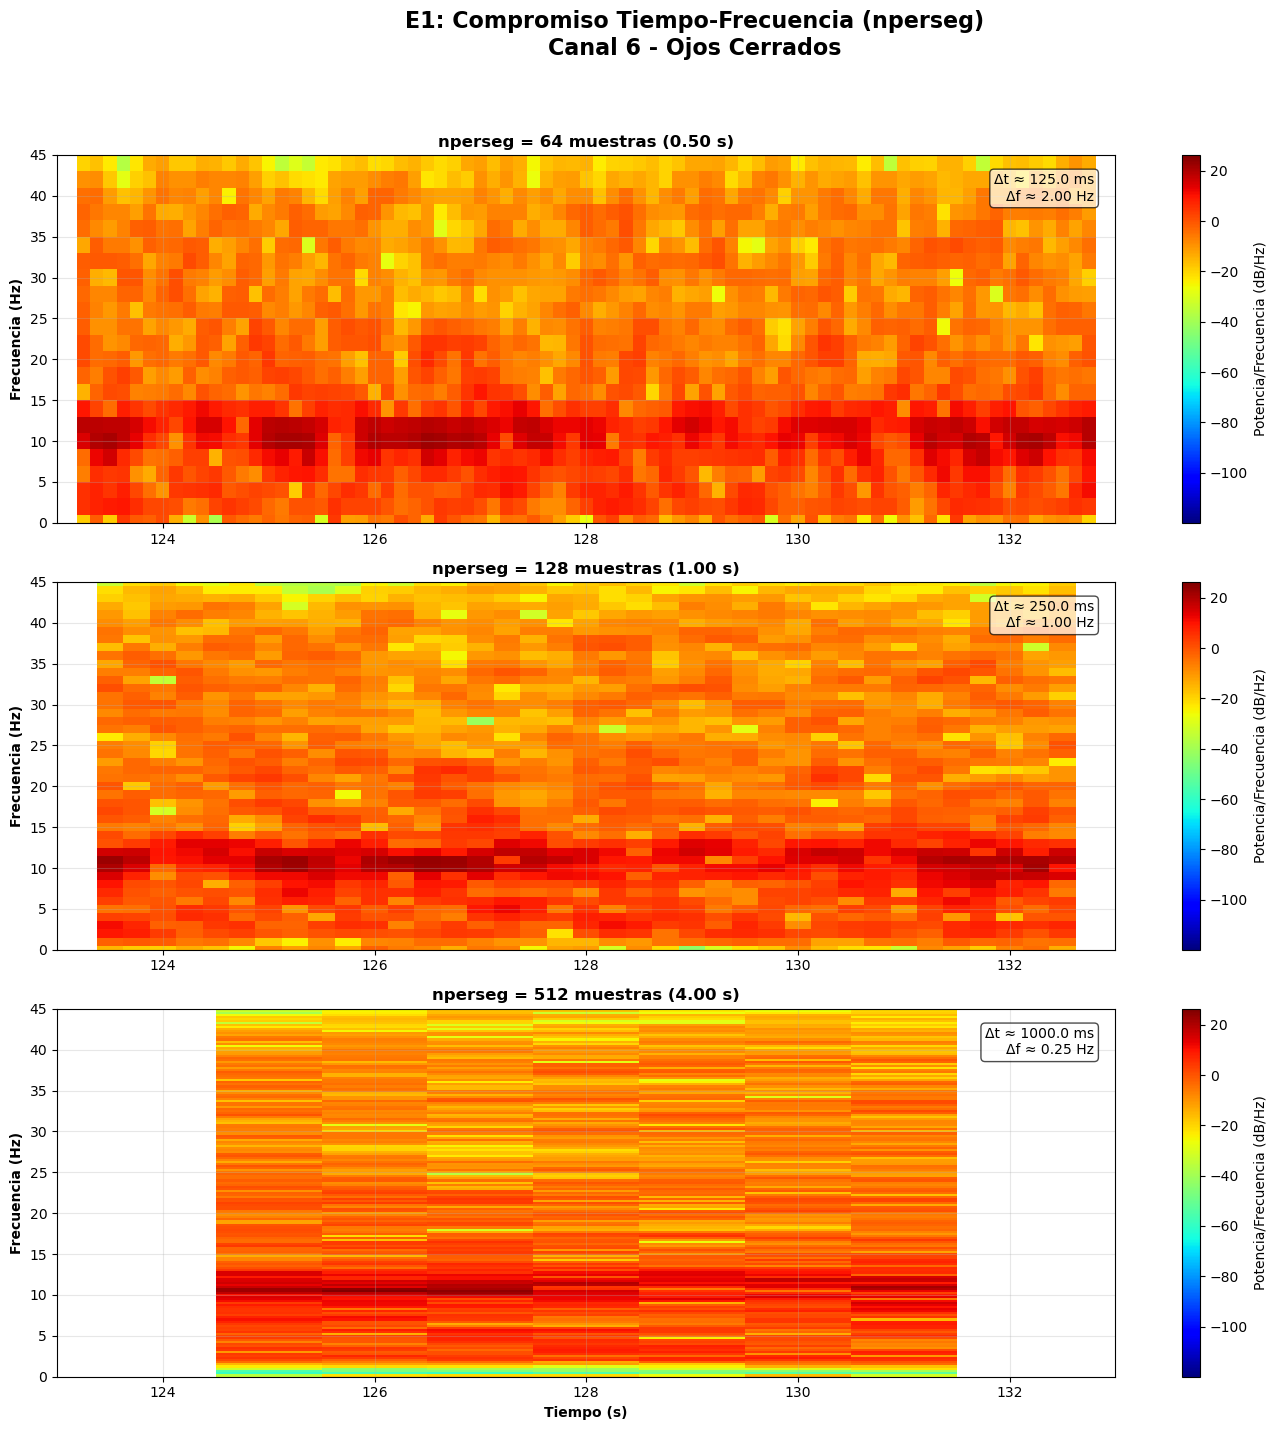

In [8]:
# Celda de Código: Ejercicio 4.E1

# --- Ejercicio 4.E1: Compromiso Tiempo-Frecuencia ---

if 'y_cerrados' in locals() and y_cerrados is not None: 
    window_lengths = [64, 128, 512] 
    noverlap_ratio = 0.75 
    
    fig_e1, axs_e1 = plt.subplots(len(window_lengths), 1, figsize=(14, 15), sharey=True)
    fig_e1.suptitle(f'E1: Compromiso Tiempo-Frecuencia (nperseg)\nCanal {nc} - Ojos Cerrados', fontsize=16, fontweight='bold')
    
    signal_segment = y_cerrados
    time_offset = ti_cerrados
    time_limit = [ti_cerrados, tf_cerrados]
    
    # Calcular vmin/vmax global para comparación justa
    vmin_e1, vmax_e1 = float('inf'), float('-inf')
    spectrograms_e1 = []
    for i, nperseg_val in enumerate(window_lengths):
        noverlap_val = int(nperseg_val * noverlap_ratio)
        f_e1, t_e1, Sxx_e1 = signal.spectrogram(signal_segment, fm, window='hann', 
                                               nperseg=nperseg_val, noverlap=noverlap_val, 
                                               scaling='density', mode='psd')
        Sxx_e1_db = 10 * np.log10(Sxx_e1 + 1e-12)
        spectrograms_e1.append({'f': f_e1, 't': t_e1, 'Sxx_db': Sxx_e1_db, 'nperseg': nperseg_val, 'noverlap': noverlap_val})
        if Sxx_e1_db.size > 0:
            vmin_e1 = min(vmin_e1, np.min(Sxx_e1_db))
            vmax_e1 = max(vmax_e1, np.max(Sxx_e1_db))
    
    # Graficar con escala de color común
    for i, spec_data in enumerate(spectrograms_e1):
        f_e1, t_e1, Sxx_e1_db = spec_data['f'], spec_data['t'], spec_data['Sxx_db']
        nperseg_val, noverlap_val = spec_data['nperseg'], spec_data['noverlap']
        
        im = axs_e1[i].pcolormesh(t_e1 + time_offset, f_e1, Sxx_e1_db, cmap='jet', shading='auto', vmin=vmin_e1, vmax=vmax_e1)
        axs_e1[i].set_title(f'nperseg = {nperseg_val} muestras ({nperseg_val/fm:.2f} s)', fontweight='bold')
        axs_e1[i].set_ylabel('Frecuencia (Hz)', fontweight='bold')
        axs_e1[i].set_ylim(0, 45)
        axs_e1[i].set_xlim(time_limit)
        fig_e1.colorbar(im, ax=axs_e1[i], label='Potencia/Frecuencia (dB/Hz)')
        axs_e1[i].grid(True, alpha=0.3)
        
        # Calcular y mostrar resoluciones
        delta_t = (nperseg_val - noverlap_val) / fm # Resolución temporal
        delta_f = fm / nperseg_val # Resolución frecuencial
        axs_e1[i].text(0.98, 0.95, f'Δt ≈ {delta_t*1000:.1f} ms\nΔf ≈ {delta_f:.2f} Hz', 
                     horizontalalignment='right', verticalalignment='top', 
                     transform=axs_e1[i].transAxes, fontsize=10, 
                     bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
    
    
    axs_e1[-1].set_xlabel('Tiempo (s)', fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Ejercicio 4.E1 no se puede ejecutar: y_cerrados no está definido. Asegúrate de ejecutar las celdas anteriores.")

### 4.E2 — Ventana y Ponderación

**Objetivo:** Comparar el efecto de diferentes tipos de ventana en la fuga espectral (spectral leakage) y la definición del espectrograma.

**Instrucciones:**
1.  Usa el mismo segmento de Ojos Cerrados (`y_cerrados`).
2.  Calcula y grafica cuatro espectrogramas (en dB) usando `nperseg=128` y `noverlap=96` (75% solapamiento), pero variando el parámetro `window`:
    * `'hann'`
    * `'hamming'`
    * `'blackman'`
    * `'bartlett'` (ventana triangular)
3.  Mantén la misma escala de color (`vmin`, `vmax`) para facilitar la comparación.
4.  Observa si hay diferencias visuales en la nitidez de la banda alfa o en la energía "derramada" a frecuencias adyacentes.

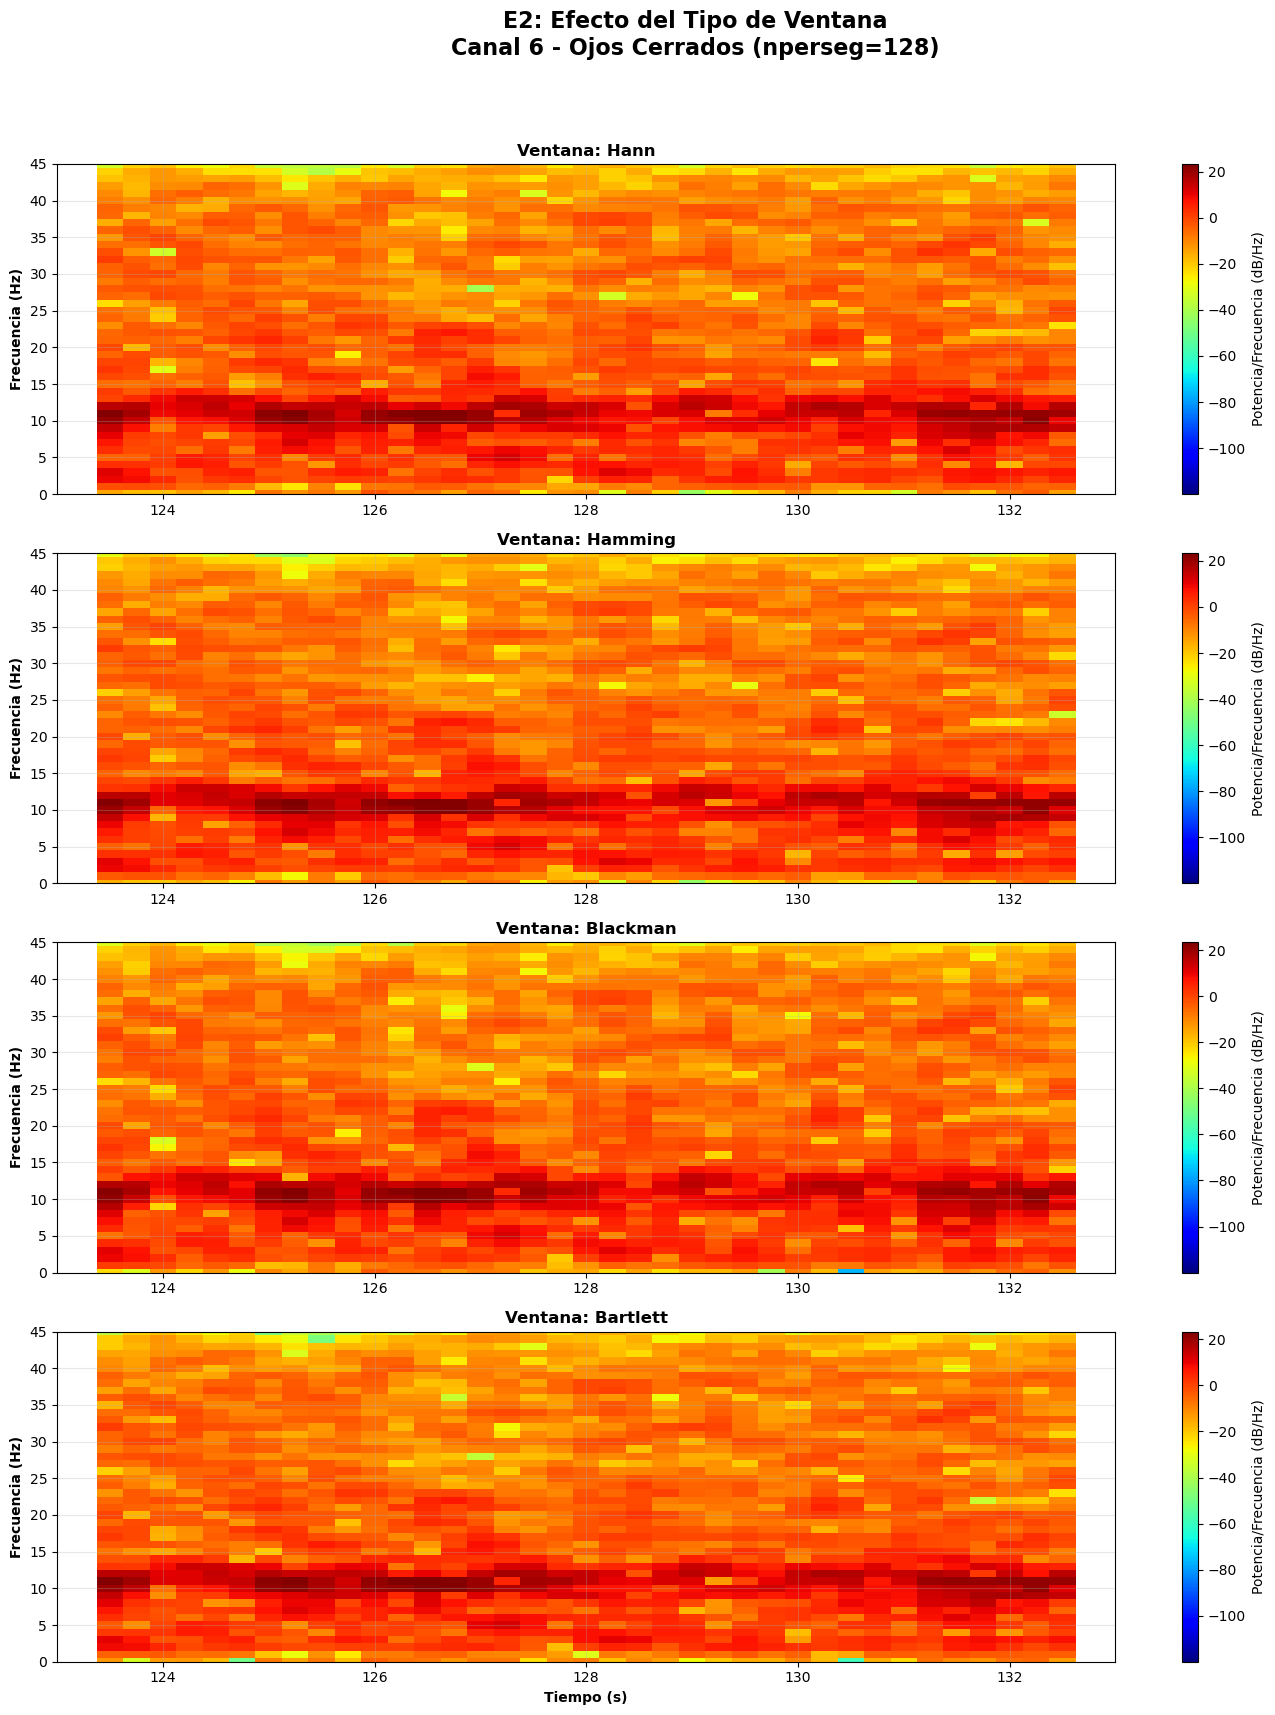

In [9]:
# Celda de Código: Ejercicio 4.E2

# --- Ejercicio 4.E2: Comparación de Ventanas ---

if 'y_cerrados' in locals() and y_cerrados is not None: 
    window_types = ['hann', 'hamming', 'blackman', 'bartlett']
    nperseg_e2 = 128
    noverlap_e2 = int(nperseg_e2 * 0.75)
    
    fig_e2, axs_e2 = plt.subplots(len(window_types), 1, figsize=(14, 18), sharey=True)
    fig_e2.suptitle(f'E2: Efecto del Tipo de Ventana\nCanal {nc} - Ojos Cerrados (nperseg=128)', fontsize=16, fontweight='bold')
    
    signal_segment = y_cerrados
    time_offset = ti_cerrados
    time_limit = [ti_cerrados, tf_cerrados]
    
    # Calcular vmin/vmax global
    vmin_e2, vmax_e2 = float('inf'), float('-inf')
    spectrograms_e2 = []
    for i, win_type in enumerate(window_types):
        f_e2, t_e2, Sxx_e2 = signal.spectrogram(signal_segment, fm, window=win_type, 
                                               nperseg=nperseg_e2, noverlap=noverlap_e2, 
                                               scaling='density', mode='psd')
        Sxx_e2_db = 10 * np.log10(Sxx_e2 + 1e-12)
        spectrograms_e2.append({'f': f_e2, 't': t_e2, 'Sxx_db': Sxx_e2_db, 'window': win_type})
        if Sxx_e2_db.size > 0:
            vmin_e2 = min(vmin_e2, np.min(Sxx_e2_db))
            vmax_e2 = max(vmax_e2, np.max(Sxx_e2_db))

    # Graficar con escala de color común
    for i, spec_data in enumerate(spectrograms_e2):
        f_e2, t_e2, Sxx_e2_db, win_type = spec_data['f'], spec_data['t'], spec_data['Sxx_db'], spec_data['window']
        
        im = axs_e2[i].pcolormesh(t_e2 + time_offset, f_e2, Sxx_e2_db, cmap='jet', shading='auto', vmin=vmin_e2, vmax=vmax_e2)
        axs_e2[i].set_title(f'Ventana: {win_type.capitalize()}', fontweight='bold')
        axs_e2[i].set_ylabel('Frecuencia (Hz)', fontweight='bold')
        axs_e2[i].set_ylim(0, 45)
        axs_e2[i].set_xlim(time_limit)
        fig_e2.colorbar(im, ax=axs_e2[i], label='Potencia/Frecuencia (dB/Hz)')
        axs_e2[i].grid(True, alpha=0.3)
    
    axs_e2[-1].set_xlabel('Tiempo (s)', fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Ejercicio 4.E2 no se puede ejecutar: y_cerrados no está definido.")

### 4.E3 — Evolución Temporal Detallada

**Objetivo:** Cuantificar y graficar la potencia por bandas ($P_b(t)$) sobre un segmento de señal *continuo* que incluya la transición de Ojos Cerrados (OC) a Ojos Abiertos (OA) para observar la dinámica del cambio.

**Instrucciones:**
1.  Define un nuevo segmento de señal (`y_trans`) que comience durante OC y termine durante OA (ej. 90s-150s), usando `t_global` (regenerado) y `datosfilt`.
2.  Define el tiempo exacto de la transición (ej. `t_evento_oa = 120`).
3.  Calcula el espectrograma (`Sxx_trans`) para este segmento.
4.  Define las bandas de interés (Theta, Alfa, Beta).
5.  Integra la potencia ($P_b(t) = \int S(t, f) df$) para cada banda a lo largo del tiempo usando `scipy.integrate.simpson`.
6.  Grafica las tres curvas de potencia ($P_{\theta}(t)$, $P_{\alpha}(t)$, $P_{\beta}(t)$).
7.  Añade una línea vertical (`axvline`) en `t_evento_oa` para marcar la transición "Ojos Abiertos".
8.  Observa la caída de la potencia Alfa (reactividad alfa).

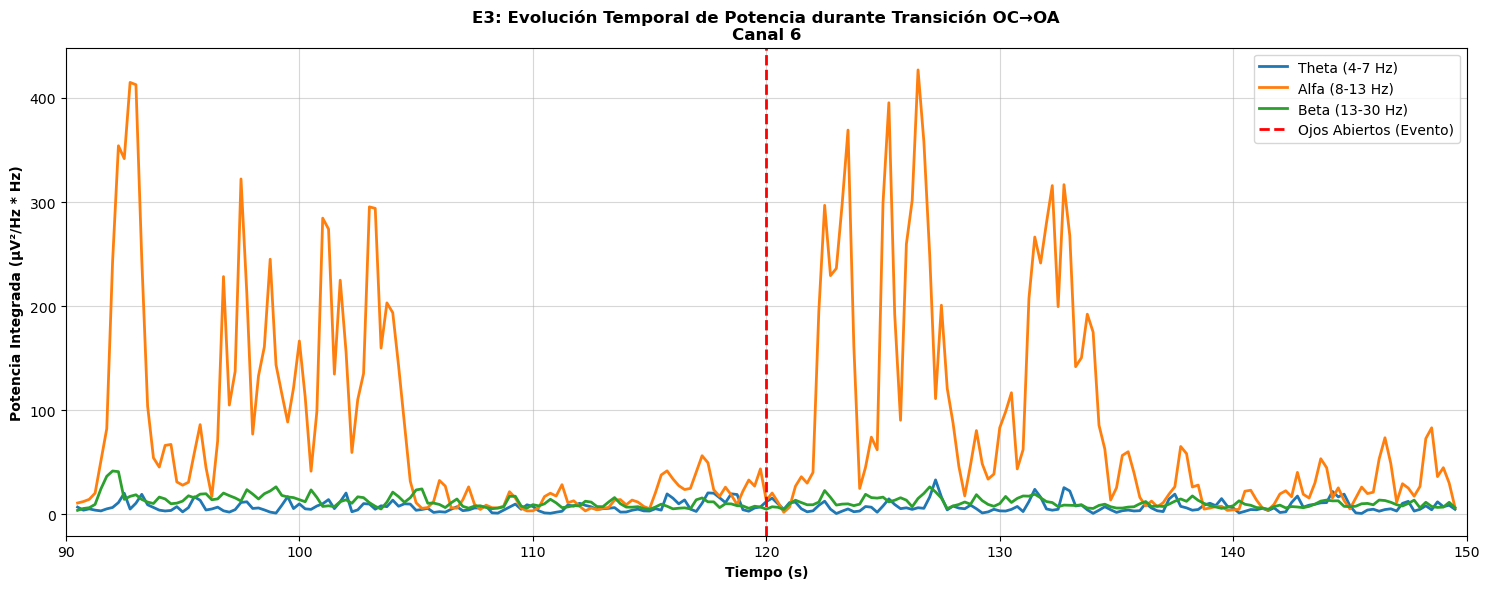

In [10]:
# Celda de Código: Ejercicio 4.E3 (Corregido)

# --- Ejercicio 4.E3: Evolución Temporal Detallada (Transición) ---

# !!! CORRECCIÓN IMPORTANTE !!!
# Las celdas In [5] e In [6] sobrescribieron la variable 't'.
# Regeneramos el vector de tiempo global (el de 23127 puntos)
# basándonos en 'eeg' y 'fm' definidas en In [3].

if 'eeg' in locals() and 'fm' in locals():
    # Regeneramos el vector de tiempo global
    t_global = np.arange(len(eeg)) / fm 
    
    # 1. Definir segmento de transición
    t_inicio_trans, t_fin_trans = 90, 150
    t_evento_oa = 120 # Momento en que se abren los ojos
    
    # *** Usar 't_global' para la máscara ***
    idx_trans = (t_global >= t_inicio_trans) & (t_global < t_fin_trans)
    y_trans = datosfilt[idx_trans, nc] # nc es el canal O1 (definido en In [5])
    
    if len(y_trans) > 0:
        # 2. Calcular espectrograma para todo el segmento
        nperseg_e3 = 128
        noverlap_e3 = int(nperseg_e3 * 0.75)
        # Usamos variables locales 'f_trans', 't_spec_trans' para la salida
        f_trans, t_spec_trans, Sxx_trans = signal.spectrogram(
            y_trans, fm, window='hann', nperseg=nperseg_e3,
            noverlap=noverlap_e3, scaling='density', mode='psd'
        )
        
        # 3. Definir bandas
        bands = {
            'Theta (4-7 Hz)': (4, 7),
            'Alfa (8-13 Hz)': (8, 13),
            'Beta (13-30 Hz)': (13, 30)
        }
        
        # 4. Integrar potencia
        band_power_matrix_trans = np.zeros((len(bands), len(t_spec_trans)))
        band_names_e3 = list(bands.keys())
        
        for i, (band_name, (low_freq, high_freq)) in enumerate(bands.items()):
            freq_indices = np.where((f_trans >= low_freq) & (f_trans <= high_freq))[0]
            if len(freq_indices) > 1:
                power_in_band = simpson(Sxx_trans[freq_indices, :], x=f_trans[freq_indices], axis=0)
                band_power_matrix_trans[i, :] = power_in_band
            elif len(freq_indices) == 1:
                 delta_f_approx = f_trans[1]-f_trans[0] if len(f_trans)>1 else 1.0
                 power_in_band = Sxx_trans[freq_indices[0], :] * delta_f_approx
                 band_power_matrix_trans[i, :] = power_in_band

        # 5. Graficar curvas
        plt.figure(figsize=(15, 6))
        ax_e3 = plt.gca()
        
        # Ajustar el vector de tiempo del espectrograma ('t_spec_trans') al tiempo global
        t_spec_global = t_spec_trans + t_inicio_trans
        
        for i, band_name in enumerate(band_names_e3):
            ax_e3.plot(t_spec_global, band_power_matrix_trans[i, :], 
                       label=band_name, linewidth=2)

        # 6. Añadir línea de evento
        ax_e3.axvline(t_evento_oa, color='r', linestyle='--', linewidth=2, label='Ojos Abiertos (Evento)')
        
        ax_e3.set_title(f'E3: Evolución Temporal de Potencia durante Transición OC→OA\nCanal {nc}', fontweight='bold')
        ax_e3.set_xlabel('Tiempo (s)', fontweight='bold')
        ax_e3.set_ylabel('Potencia Integrada (μV²/Hz * Hz)', fontweight='bold')
        ax_e3.legend()
        ax_e3.grid(True, alpha=0.5)
        ax_e3.set_xlim(t_inicio_trans, t_fin_trans)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("Ejercicio 4.E3 no se puede ejecutar: El segmento de transición está vacío.")
else:
    print("Ejercicio 4.E3 no se puede ejecutar: 'eeg' o 'fm' no están definidos. Asegúrate de ejecutar la celda In [3].")

### 4.E4 — Mapa de Energía Relativa por Bandas

**Objetivo:** Crear un mapa de calor que muestre la *potencia relativa* de cada banda (Theta, Alfa, Beta) a lo largo del tiempo, usando el mismo segmento de transición de E3.

**Instrucciones:**
1.  Utiliza los datos de potencia integrada por banda ($P_b(t)$) calculados en E3 (la matriz `band_power_matrix_trans`) y el vector de tiempo del espectrograma (`t_spec_trans`).
2.  Para cada instante de tiempo $t$, calcula la potencia total $P_{\text{total}}(t)$ sumando las potencias de las tres bandas.
3.  Normaliza la potencia de cada banda dividiéndola por la potencia total en ese instante: $P_{\text{rel}, b}(t) = (P_b(t) / P_{\text{total}}(t)) \times 100\%$.
4.  Crea un mapa de calor (heatmap) usando `plt.pcolormesh`.
5.  Añade una línea vertical (`axvline`) en `t_evento_oa` (120s) para marcar la transición.
6.  Interpreta el mapa, describiendo el cambio en la *dominancia* de las bandas.

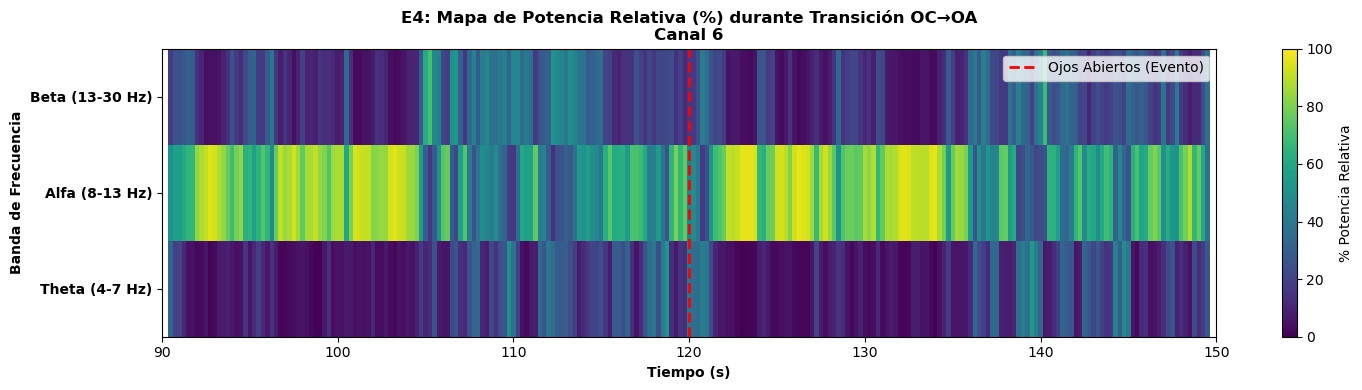

In [11]:
# Celda de Código: Ejercicio 4.E4 (Corregido)

# --- Ejercicio 4.E4: Mapa de Energía Relativa por Bandas ---

# Requerimos las variables 'Sxx_trans' y 'band_power_matrix_trans' de E3
if 'Sxx_trans' in locals() and 'band_power_matrix_trans' in locals():

    # 2. Calcular potencia total
    total_power_per_time_e4 = np.sum(band_power_matrix_trans, axis=0)
    # Evitar división por cero
    total_power_per_time_e4[total_power_per_time_e4 <= 1e-12] = 1 
    
    # 3. Normalizar
    normalized_power_matrix_e4 = (band_power_matrix_trans / total_power_per_time_e4) * 100 # Porcentaje
    band_names_e4 = list(bands.keys()) # Obtener los nombres de las bandas
    
    # 4. Crear heatmap
    plt.figure(figsize=(15, 4)) # Crea la figura
    ax_e4 = plt.gca()
    
    im_e4 = ax_e4.pcolormesh(
        t_spec_trans + t_inicio_trans, # Eje X (centros de tiempo)
        np.arange(len(band_names_e4)), # Eje Y (centros de banda)
        normalized_power_matrix_e4,    # Datos (C)
        cmap='viridis', 
        shading='nearest', 
        vmin=0, vmax=100 
    )
                       
    ax_e4.set_yticks(np.arange(len(band_names_e4)))
    ax_e4.set_yticklabels(band_names_e4, fontweight='bold')
    ax_e4.set_title(f'E4: Mapa de Potencia Relativa (%) durante Transición OC→OA\nCanal {nc}', fontweight='bold')
    ax_e4.set_xlabel('Tiempo (s)', fontweight='bold')
    ax_e4.set_ylabel('Banda de Frecuencia', fontweight='bold')
    
    # 5. Añadir línea de evento
    ax_e4.axvline(t_evento_oa, color='r', linestyle='--', linewidth=2, label='Ojos Abiertos (Evento)')
    ax_e4.legend(loc='upper right')

    # *** CORRECCIÓN AQUÍ: Usar 'plt.colorbar' en lugar de 'fig_e4.colorbar' ***
    plt.colorbar(im_e4, ax=ax_e4, label='% Potencia Relativa')
    
    ax_e4.set_xlim(t_inicio_trans, t_fin_trans)

    plt.tight_layout()
    plt.show()

else:
     print("Ejercicio 4.E4 no se puede ejecutar: los datos de E3 no están definidos. Ejecuta la celda E3 primero.")

### 4.E5 — Análisis de otro canal (Frontal)

**Objetivo:** Comparar el espectrograma occipital (O1), donde se espera la reactividad alfa, con un canal frontal (ej. Fp1).

**Instrucciones:**
1.  Define el índice del canal frontal `canal_fp1` (ej. `0` para Fp1).
2.  Extrae el mismo segmento de señal de transición (ej. 90s-150s) para este canal frontal (`y_trans_fp1`) usando `t_global` y `datosfilt`.
3.  Calcula el espectrograma (en dB) para el canal Fp1 (`Sxx_fp1_db`).
4.  Reutiliza el espectrograma del canal O1 del ejercicio E3 (`Sxx_trans`).
5.  Grafica el espectrograma de O1 (Occipital) y el nuevo espectrograma de Fp1 (Frontal) uno encima del otro.
6.  Usa una escala de color (`vmin`, `vmax`) *global* (calculada a partir de ambos espectrogramas) para una comparación válida.
7.  Añade la línea vertical en `t_evento_oa` (120s) a ambos gráficos.
8.  Compara los dos gráficos: ¿Se observa la reactividad alfa en Fp1? ¿Qué diferencias generales (artefactos, bandas dominantes) observas?

Comparando Canal 6 (Occipital) vs Canal 0 (Frontal)
Escala de color global (dB/Hz): min=-120.00, max=23.85


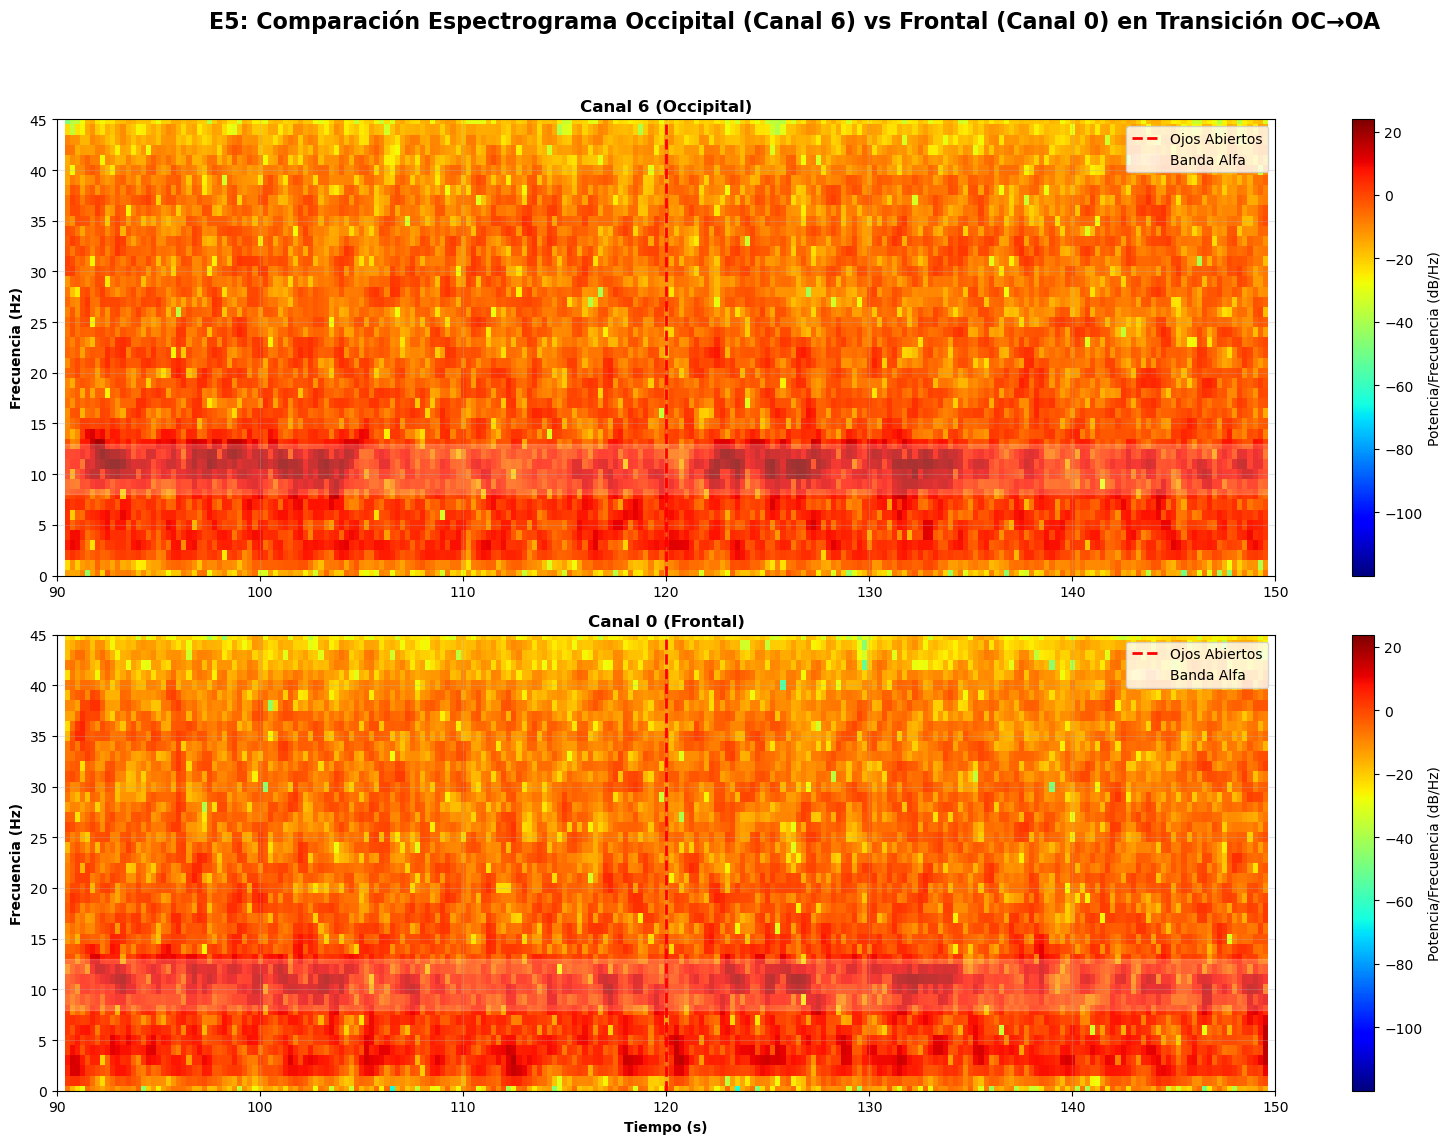

In [12]:
# Celda de Código: Ejercicio 4.E5 (Corregido)

# --- Ejercicio 4.E5: Análisis de otro canal (Frontal Fp1) ---

# Requerimos 't_global', 'datosfilt', 'nc', 'fm', 't_spec_trans', 'Sxx_trans'
if 't_global' in locals() and 'datosfilt' in locals() and 'Sxx_trans' in locals():
    
    # 1. Identificar canales
    canal_o1 = nc # Índice de O1 (ej. 6)
    canal_fp1 = 0  # Asumir que el índice 0 es Fp1
    
    print(f"Comparando Canal {canal_o1} (Occipital) vs Canal {canal_fp1} (Frontal)")

    # 2. Extraer segmento Fp1
    t_inicio_trans, t_fin_trans = 90, 150
    t_evento_oa = 120
    # *** CORRECCIÓN AQUÍ: Usar 't_global' para la máscara ***
    idx_trans = (t_global >= t_inicio_trans) & (t_global < t_fin_trans)
    
    if len(idx_trans) > 0 and datosfilt.shape[1] > max(canal_o1, canal_fp1):
        y_trans_fp1 = datosfilt[idx_trans, canal_fp1]
        
        # 3. Calcular espectrograma Fp1
        nperseg_e5 = 128
        noverlap_e5 = int(nperseg_e5 * 0.75)
        
        # Usamos variables locales 'f_fp1', 't_spec_fp1'
        f_fp1, t_spec_fp1, Sxx_fp1 = signal.spectrogram(
            y_trans_fp1, fm, window='hann', nperseg=nperseg_e5,
            noverlap=noverlap_e5, scaling='density', mode='psd'
        )
        
        # 4. Re-obtener datos de O1 (de E3)
        f_o1, t_spec_o1, Sxx_o1 = f_trans, t_spec_trans, Sxx_trans
        
        # Convertir ambos a dB
        Sxx_o1_db = 10 * np.log10(Sxx_o1 + 1e-12)
        Sxx_fp1_db = 10 * np.log10(Sxx_fp1 + 1e-12)

        # 5. Encontrar vmin/vmax global
        vmin_e5 = np.min([Sxx_o1_db.min(), Sxx_fp1_db.min()])
        vmax_e5 = np.max([Sxx_o1_db.max(), Sxx_fp1_db.max()])
        print(f"Escala de color global (dB/Hz): min={vmin_e5:.2f}, max={vmax_e5:.2f}")

        # 6. Graficar
        fig_e5, (ax1_e5, ax2_e5) = plt.subplots(2, 1, figsize=(16, 12), sharey=True)
        fig_e5.suptitle(f'E5: Comparación Espectrograma Occipital (Canal {canal_o1}) vs Frontal (Canal {canal_fp1}) en Transición OC→OA', fontsize=16, fontweight='bold')
        
        # Gráfico O1
        im1_e5 = ax1_e5.pcolormesh(t_spec_o1 + t_inicio_trans, f_o1, Sxx_o1_db, cmap='jet', shading='auto', vmin=vmin_e5, vmax=vmax_e5)
        ax1_e5.set_title(f'Canal {canal_o1} (Occipital)', fontweight='bold')
        ax1_e5.set_ylabel('Frecuencia (Hz)', fontweight='bold')
        ax1_e5.set_ylim(0, 45)
        ax1_e5.set_xlim(t_inicio_trans, t_fin_trans)
        ax1_e5.axvline(t_evento_oa, color='r', linestyle='--', linewidth=2, label='Ojos Abiertos')
        ax1_e5.axhspan(8, 13, alpha=0.2, color='white', label='Banda Alfa')
        ax1_e5.legend(loc='upper right')
        ax1_e5.grid(True, alpha=0.3)
        fig_e5.colorbar(im1_e5, ax=ax1_e5, label='Potencia/Frecuencia (dB/Hz)')

        # Gráfico Fp1
        im2_e5 = ax2_e5.pcolormesh(t_spec_fp1 + t_inicio_trans, f_fp1, Sxx_fp1_db, cmap='jet', shading='auto', vmin=vmin_e5, vmax=vmax_e5)
        ax2_e5.set_title(f'Canal {canal_fp1} (Frontal)', fontweight='bold')
        ax2_e5.set_xlabel('Tiempo (s)', fontweight='bold')
        ax2_e5.set_ylabel('Frecuencia (Hz)', fontweight='bold')
        ax2_e5.set_ylim(0, 45)
        ax2_e5.set_xlim(t_inicio_trans, t_fin_trans)
        ax2_e5.axvline(t_evento_oa, color='r', linestyle='--', linewidth=2, label='Ojos Abiertos')
        ax2_e5.axhspan(8, 13, alpha=0.2, color='white', label='Banda Alfa')
        ax2_e5.legend(loc='upper right')
        ax2_e5.grid(True, alpha=0.3)
        fig_e5.colorbar(im2_e5, ax=ax2_e5, label='Potencia/Frecuencia (dB/Hz)')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
    else:
        print("Ejercicio 4.E5 no se puede ejecutar: El segmento de transición está vacío o los índices de canal no son válidos.")
else:
     print("Ejercicio 4.E5 no se puede ejecutar: 't_global' o 'datosfilt' o 'Sxx_trans' no están definidos.")

## 4.7 Reflexión final

La Transformada de Fourier de Tiempo Corto (STFT) y los espectrogramas son herramientas poderosas que extienden el análisis de Fourier al dominio del tiempo-frecuencia. Son esenciales para analizar señales **no estacionarias** como el EEG, donde la composición frecuencial cambia constantemente (Cohen, 2014). Como vimos en los ejercicios, la STFT nos permitió visualizar dinámicas cruciales, como la reactividad alfa (la atenuación de la potencia alfa al abrir los ojos), un fenómeno que la FFT o la PSD tradicional habrían ocultado al promediar todo el segmento de tiempo (Hsu et al., 2021).

La ventaja principal de la STFT es su capacidad para responder *cuándo* (tiempo) ocurren ciertos eventos frecuenciales (Boashash, 2016).

Sin embargo, la STFT tiene una limitación fundamental: su **resolución tiempo-frecuencia es fija**. Esta resolución está determinada por la longitud de la ventana (`nperseg`) que elegimos (Allen & Rabiner, 1977).

* Como vimos en el Ejercicio 4.E1, una **ventana corta** (ej. 64 muestras) nos da una excelente resolución temporal (podemos ver *cuándo* ocurren los cambios) pero una pobre resolución frecuencial (las bandas de frecuencia se ven "borrosas" y anchas).
* Por el contrario, una **ventana larga** (ej. 512 muestras) nos da una excelente resolución frecuencial (la banda alfa aparece como una línea nítida) pero una pobre resolución temporal (los eventos rápidos se promedian y se "embarran" en el tiempo).

Este compromiso, dictado por el Principio de Incertidumbre (Cohen, 1995), significa que una ventana única de STFT no puede ser óptima para analizar simultáneamente fenómenos rápidos (como picos o transitorios gamma) y fenómenos lentos (como ritmos delta) en el EEG (Cohen, 2014).

## 4.8 Puente hacia el análisis adaptativo

La limitación de la ventana fija de la STFT es problemática porque el cerebro no opera en una única escala de tiempo. Para analizar frecuencias bajas (como delta, ~2 Hz) necesitamos ventanas largas (de varios segundos), pero esas mismas ventanas ocultarán por completo los eventos rápidos de alta frecuencia (como gamma, ~40 Hz), que duran solo milisegundos.

Para superar esto, necesitamos métodos de análisis tiempo-frecuencia que puedan **adaptar** su resolución a las características de la señal. Los próximos notebooks explorarán dos de estos enfoques adaptativos:

1.  **Transformada de Hilbert (Análisis de Fase/Amplitud Instantánea):**
    En lugar de promediar la potencia en una ventana, la Transformada de Hilbert nos permite calcular la **amplitud instantánea** y la **fase instantánea** de una señal (Richardson, 2018). Al aplicar esto a una señal previamente filtrada en una banda de interés (ej. filtrar solo la banda alfa), podemos rastrear, milisegundo a milisegundo, cómo la *amplitud* (potencia) de esa banda sube y baja, y cómo su *frecuencia* exacta cambia en el tiempo. Este enfoque es fundamental en la neurociencia contemporánea, permitiendo estudios de acoplamiento fase-amplitud (Tort et al., 2010) y siendo la base de la Transformada de Hilbert-Huang (Huang & Shen, 2005).

2.  **Transformada Wavelet (Ondeleta):**
    La Transformada Wavelet (específicamente la Transformada Wavelet Continua o CWT) resuelve el compromiso de la STFT mediante el uso de una **resolución variable** o **multiescala** (Addison, 2017). A diferencia de la STFT (análisis tiempo-frecuencia), la CWT es un análisis tiempo-escala (Flandrin, 1999) que utiliza "wavelets" (pequeñas ondas) que cambian de tamaño (escala):
    * Para **altas frecuencias** (ej. gamma), usa wavelets cortas y "comprimidas", logrando una **excelente resolución temporal**.
    * Para **bajas frecuencias** (ej. delta), usa wavelets largas y "estiradas", logrando una **excelente resolución frecuencial** (Mallat, 2009).

    Este enfoque de "zoom" adaptativo es mucho más adecuado para analizar señales biológicas complejas como el EEG, que contienen eventos rápidos y lentos ocurriendo simultáneamente.

Estos métodos forman la conexión natural con el **Notebook 5**, donde exploraremos el poder del análisis de Hilbert y Wavelet para descomponer el EEG de una manera que la STFT no puede lograr.

## 4.9 Bibliografía

Allen, J. B., & Rabiner, L. R. (1977). A unified approach to short-time Fourier analysis and synthesis. *Proceedings of the IEEE*, 65(11), 1558-1564.

Buzsáki, G., & Draguhn, A. (2004). Neuronal oscillations in cortical networks. *Science*, 304(5679), 1926-1929.

Cohen, M. X. (2019). *Analyzing neural time series data: theory and practice*. MIT Press.

Gabor, D. (1946). Theory of communication. Part 1: The analysis of information. *Journal of the Institution of Electrical Engineers-Part III: Radio and Communication Engineering*, 93(26), 429-441.

Harris, F. J. (1978). On the use of windows for harmonic analysis with the discrete Fourier transform. *Proceedings of the IEEE*, 66(1), 51-83.

Klimesch, W. (2012). Alpha-band oscillations, attention, and controlled access to stored information. *Trends in Cognitive Sciences*, 16(12), 606-617.

Ng, S. C., Raveendran, P., & Dlay, S. (2022). Time-frequency analysis of EEG signals for brain-computer interface applications. In *Handbook of Neural Engineering* (pp. 345-367). Springer.

Oppenheim, A. V., Schafer, R. W., & Buck, J. R. (2010). *Discrete-time signal processing* (3rd ed.). Pearson.

Ramos-Argüelles, F., Morales, G., Egozcue, S., Pabón, R. M., & Alonso, M. T. (2009). Técnicas básicas de electroencefalografía: principios y aplicaciones clínicas. *Anales del Sistema Sanitario de Navarra*, 32(Supl. 3), 69-82.

Sejdić, E., Djurović, I., & Jiang, J. (2009). Time–frequency feature representation using energy concentration: An overview of recent advances. *Digital Signal Processing*, 19(1), 153-173.

Widmann, A., Schröger, E., & Maess, B. (2015). Digital filter design for electrophysiological data–a practical approach. *Journal of Neuroscience Methods*, 250, 34-46.